# Cross validaition

`FEEMS` employs a penalized likelihood for estimating two sets of parameters: edge weights and node-specific variances. For ease of use, `FEEMS` fixed the node-specific variances to be constant and only estimated the edge weights. To prevent overfitting on these weights, it employed a smoothing parameter called `lamb` to ensure similarity amongst neighboring edges (so a higher value of `lamb` will result in smoother surfaces in `FEEMS`). This appropriate value for `lamb` was found through a leave-one-out cross-validation approach (highlighted below). 

In _v2.0_ of `FEEMS`, we reintroduce a mode of fitting in which a separate value is estimated for each node. Very roughly, this node-specific value is proportional to heterozygosity within a particular sampled deme. Similarly, we also include a term called `lamb_q` to ensure some smoothness over these node-specific parameters across the grid. We will now use a cross-validation approach to find the combination of `lamb` and `lamb_q` that provides the lowest error. 

## Imports

First we import the required packages and `FEEMS`:

In [627]:
# base
import numpy as np
from importlib import resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz
from feems.cross_validation import run_cv, run_cv_joint

# change matplotlib fonts
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.sans-serif"] = "Helvetica"

## Data

In [630]:
data_path = resources.files("feems") / "data/"

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

# construct spatial graph object
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 83.19it/s]


Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.


## Run cross-validation

We will demonstrate commands to run cross-validation on both `lamb` and `lamb_q`. Typically, in our testing we've found $1e-3$ as a good lower bound for `lamb`, and for `lamb_q` we recommend searching over just $5$ values $[0.01, 0.1, 1, 10, 100]$ to reflect the different magnitudes on the penalties of the heterozygosities. 

(We will demonstrate this with `n_folds=5`, but the default (if left blank) will be leave-one-out)

In [744]:
?run_cv_joint

Signature:
run_cv_joint(
    sp_graph,
    lamb_grid,
    lamb_q_grid,
    alpha_cv=None,
    alpha_q=None,
    n_folds=None,
    lb=1e-06,
    ub=1000000.0,
    factr=10000000000.0,
    random_state=500,
    outer_verbose=True,
    inner_verbose=False,
    alpha_fact=1.0,
)
Docstring: Run cross validation on lamb & lamb_q, but holding alpha & alpha_q fixed at constant values (best-fit from constant model)
File:      ~/src/feems/feems/cross_validation.py
Type:      function

In [631]:
%%time
# define grids
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-3, 1e2, 10, endpoint=True)[::-1]
lamb_q_grid = np.geomspace(1e-2, 1e2, 5, endpoint=True)[::-1]

# run cross-validation over both smoothing parameters
# ~NEW~ function
cv_err = run_cv_joint(sp_graph, lamb_grid, lamb_q_grid, n_folds=5, factr=1e10)

# average over folds
mean_cv_err = np.mean(cv_err, axis=0)


 fold:  0
iteration lambda=10/10 lambda_q=5/5
 fold:  1
iteration lambda=10/10 lambda_q=5/5
 fold:  2
iteration lambda=10/10 lambda_q=5/5
 fold:  3
iteration lambda=10/10 lambda_q=5/5
 fold:  4
iteration lambda=10/10 lambda_q=5/5CPU times: user 31min 10s, sys: 4min 30s, total: 35min 40s
Wall time: 9min 55s


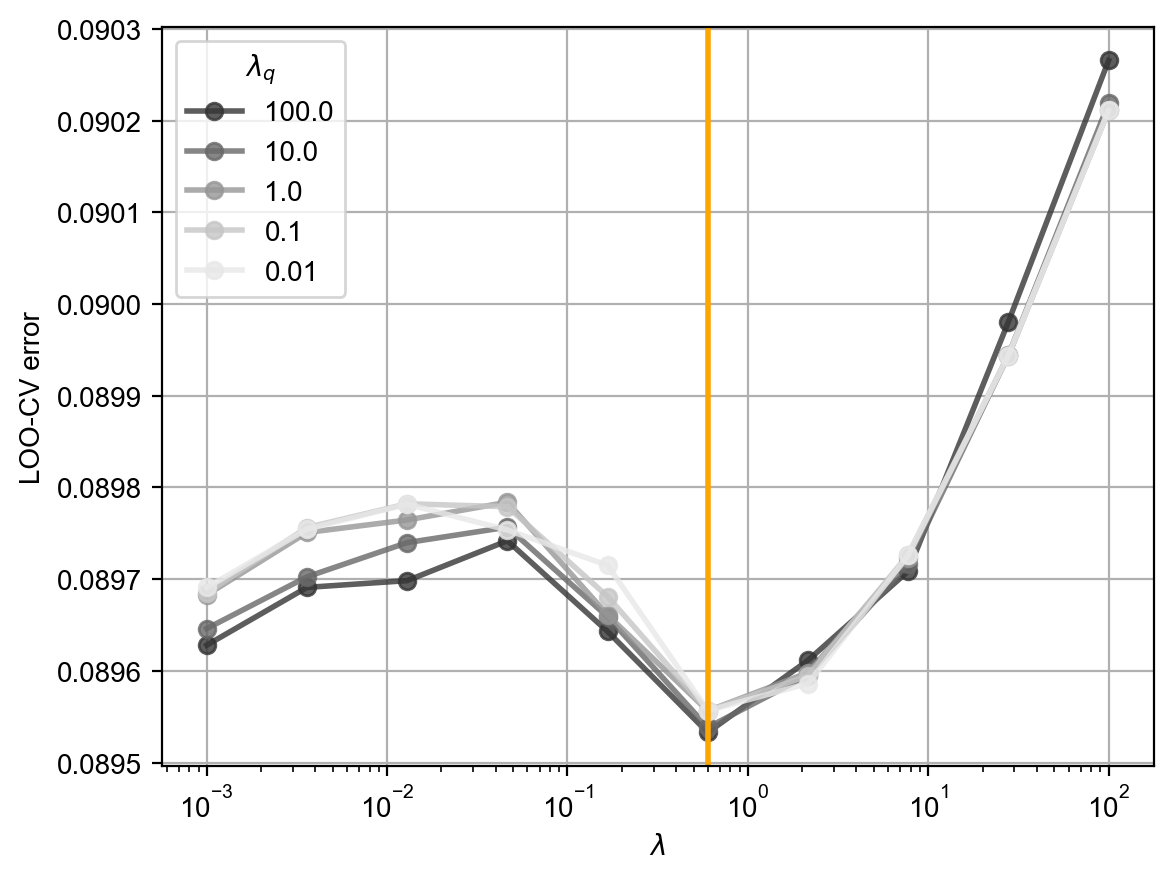

In [633]:
# lamb & lamb_q CV values
lamb_q_cv = lamb_q_grid[np.where(mean_cv_err == np.min(mean_cv_err))[0][0]]
lamb_cv = lamb_grid[np.where(mean_cv_err == np.min(mean_cv_err))[1][0]]

# plot the figure of CV error
plt.figure(dpi = 200)
plt.gca().set_prop_cycle(color=[plt.get_cmap('Greys_r').resampled(len(lamb_q_grid)+2)(i) for i in range(1,len(lamb_q_grid)+1)])
lineObj = plt.plot(lamb_grid, mean_cv_err.T, '-o', linewidth = 2, alpha = 0.8)
plt.legend(lineObj, lamb_q_grid, title=r'$\lambda_q$'); plt.grid()
plt.xlabel(r'$\lambda$'); plt.semilogx(); plt.ylabel('LOO-CV error')
plt.axvline(lamb_cv, linewidth = 2, color = 'orange')

From the above results, we see that `lamb_cv ≈ 0.5`, but this is for `n_folds=5`. We also observe that there are very similar error rates for `lamb_q = 1, 10, 100`, even though technically, `lamb_q_cv = 100`. We will see how these different parameters influence the final fit.  

Text(0.2, 0.85, 'lambda=0.00\nlambda_q=0.01\ncv l2 error=0.08975')

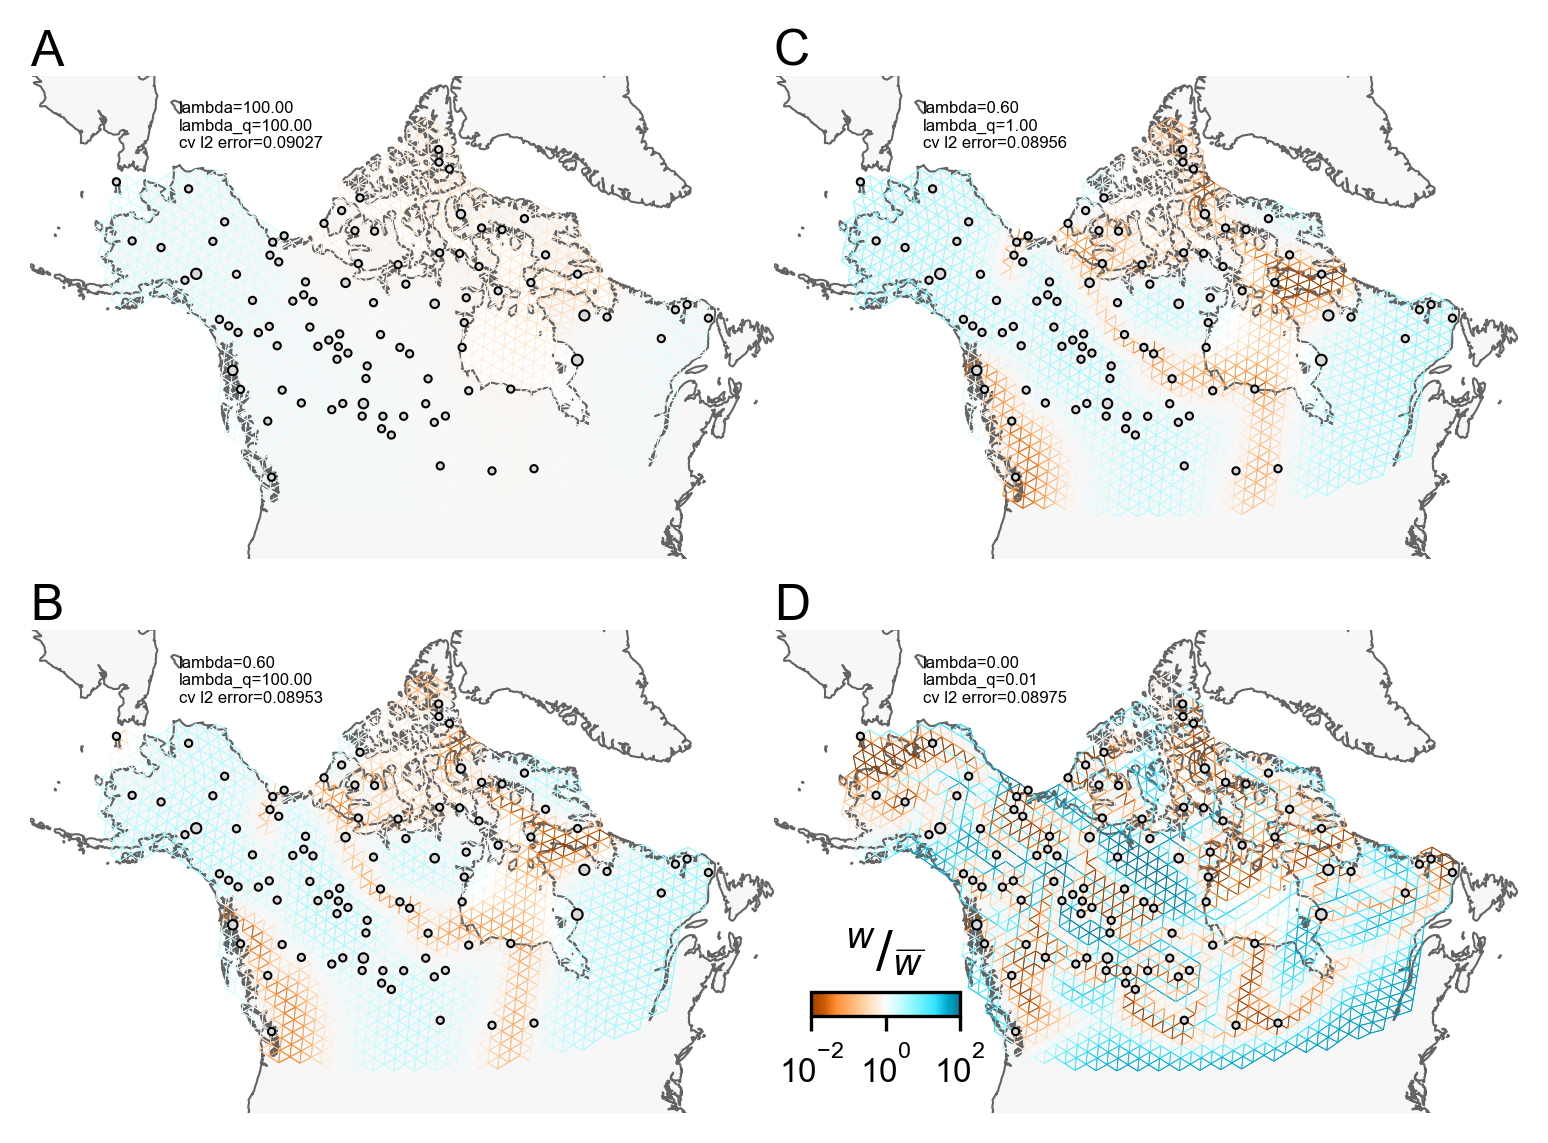

In [654]:
# figure params
projection = ccrs.AzimuthalEquidistant(central_longitude=-108.842926, central_latitude=66.037547)
title_loc = "left"
title_pad = "-10"
title_fontsize = 12
edge_width = .2
edge_alpha = 1
edge_zorder = 3
obs_node_size = 3
obs_node_linewidth = .4
cbar_font_size = 8
cbar_ticklabelsize = 8
cbar_orientation = "horizontal"

# figure setup
fig = plt.figure(dpi=300)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, wspace=0.0, hspace=0.0)

# axis 00 
ax_00 = fig.add_subplot(spec[0, 0], projection=projection)
ax_00.set_title("A", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(lamb=lamb_grid[0], lamb_q=lamb_q_grid[0])
v = Viz(ax_00, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(longlat=False)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_00.text(.2, .85, "lambda={:.2f}\nlambda_q={:.2f}\ncv l2 error={:.5f}".format(lamb_grid[0], lamb_q_grid[0], mean_cv_err[0, 0]), 
           fontdict={"fontsize": 4}, transform = ax_00.transAxes)

# axis 10
ax_10 = fig.add_subplot(spec[1, 0], projection=projection)
ax_10.set_title("B", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(lamb=lamb_cv, lamb_q=lamb_q_cv)
v = Viz(ax_10, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20,
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(longlat=False)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_10.text(.2, .85, "lambda={:.2f}\nlambda_q={:.2f}\ncv l2 error={:.5f}".format(lamb_cv, lamb_q_cv, mean_cv_err[np.where(lamb_q_cv==lamb_q_grid)[0][0], np.where(lamb_cv==lamb_grid)[0][0]]), 
           fontdict={"fontsize": 4}, transform = ax_10.transAxes)

# axis 01
ax_01 = fig.add_subplot(spec[0, 1], projection=projection)
ax_01.set_title("C", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(lamb=lamb_cv, lamb_q=0.01*lamb_q_cv)
v = Viz(ax_01, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(longlat=False)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_01.text(.2, .85, "lambda={:.2f}\nlambda_q={:.2f}\ncv l2 error={:.5f}".format(lamb_cv, 0.01*lamb_q_cv, mean_cv_err[np.where(0.01*lamb_q_cv==lamb_q_grid)[0][0], np.where(lamb_cv==lamb_grid)[0][0]]), 
           fontdict={"fontsize": 4}, transform = ax_01.transAxes)

# axis 11
ax_11 = fig.add_subplot(spec[1, 1], projection=projection)
ax_11.set_title("D", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(lamb=lamb_grid[-2], lamb_q=lamb_q_grid[-1])
v = Viz(ax_11, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(longlat=False)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
v.cbar_font_size = cbar_font_size
v.cbar_orientation = cbar_orientation
v.cbar_ticklabelsize = cbar_ticklabelsize
v.draw_edge_colorbar()
ax_11.text(.2, .85, "lambda={:.2f}\nlambda_q={:.2f}\ncv l2 error={:.5f}".format(lamb_grid[-2], lamb_q_grid[-1], mean_cv_err[-1, -2]), 
           fontdict={"fontsize": 4}, transform = ax_11.transAxes)

## _v1.0_ (running cross-validation only on `lamb`)

Next we perform leave-one-out cross-valiation (CV) over a grid of $\lambda$ values (`lamb`). In our CV we hold out indivudal observed nodes on the graph, predict allele frequencies at the held-out node under our fitted model, and use the $\ell_2$ distance between the fitted and predicted allele frequencies as our CV metric to select models: 

In [655]:
%%time
# define grids
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-3, 1e2, 10, endpoint=True)[::-1]

# run cross-validation
cv_err = run_cv(sp_graph, lamb_grid, n_folds=5, factr=1e10)

# average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])


 fold:  0
iteration lambda=10/10 alpha=1/1
 fold:  1
iteration lambda=10/10 alpha=1/1
 fold:  2
iteration lambda=10/10 alpha=1/1
 fold:  3
iteration lambda=10/10 alpha=1/1
 fold:  4
iteration lambda=10/10 alpha=1/1CPU times: user 7min 34s, sys: 1min 13s, total: 8min 47s
Wall time: 2min 34s


Plot CV error:

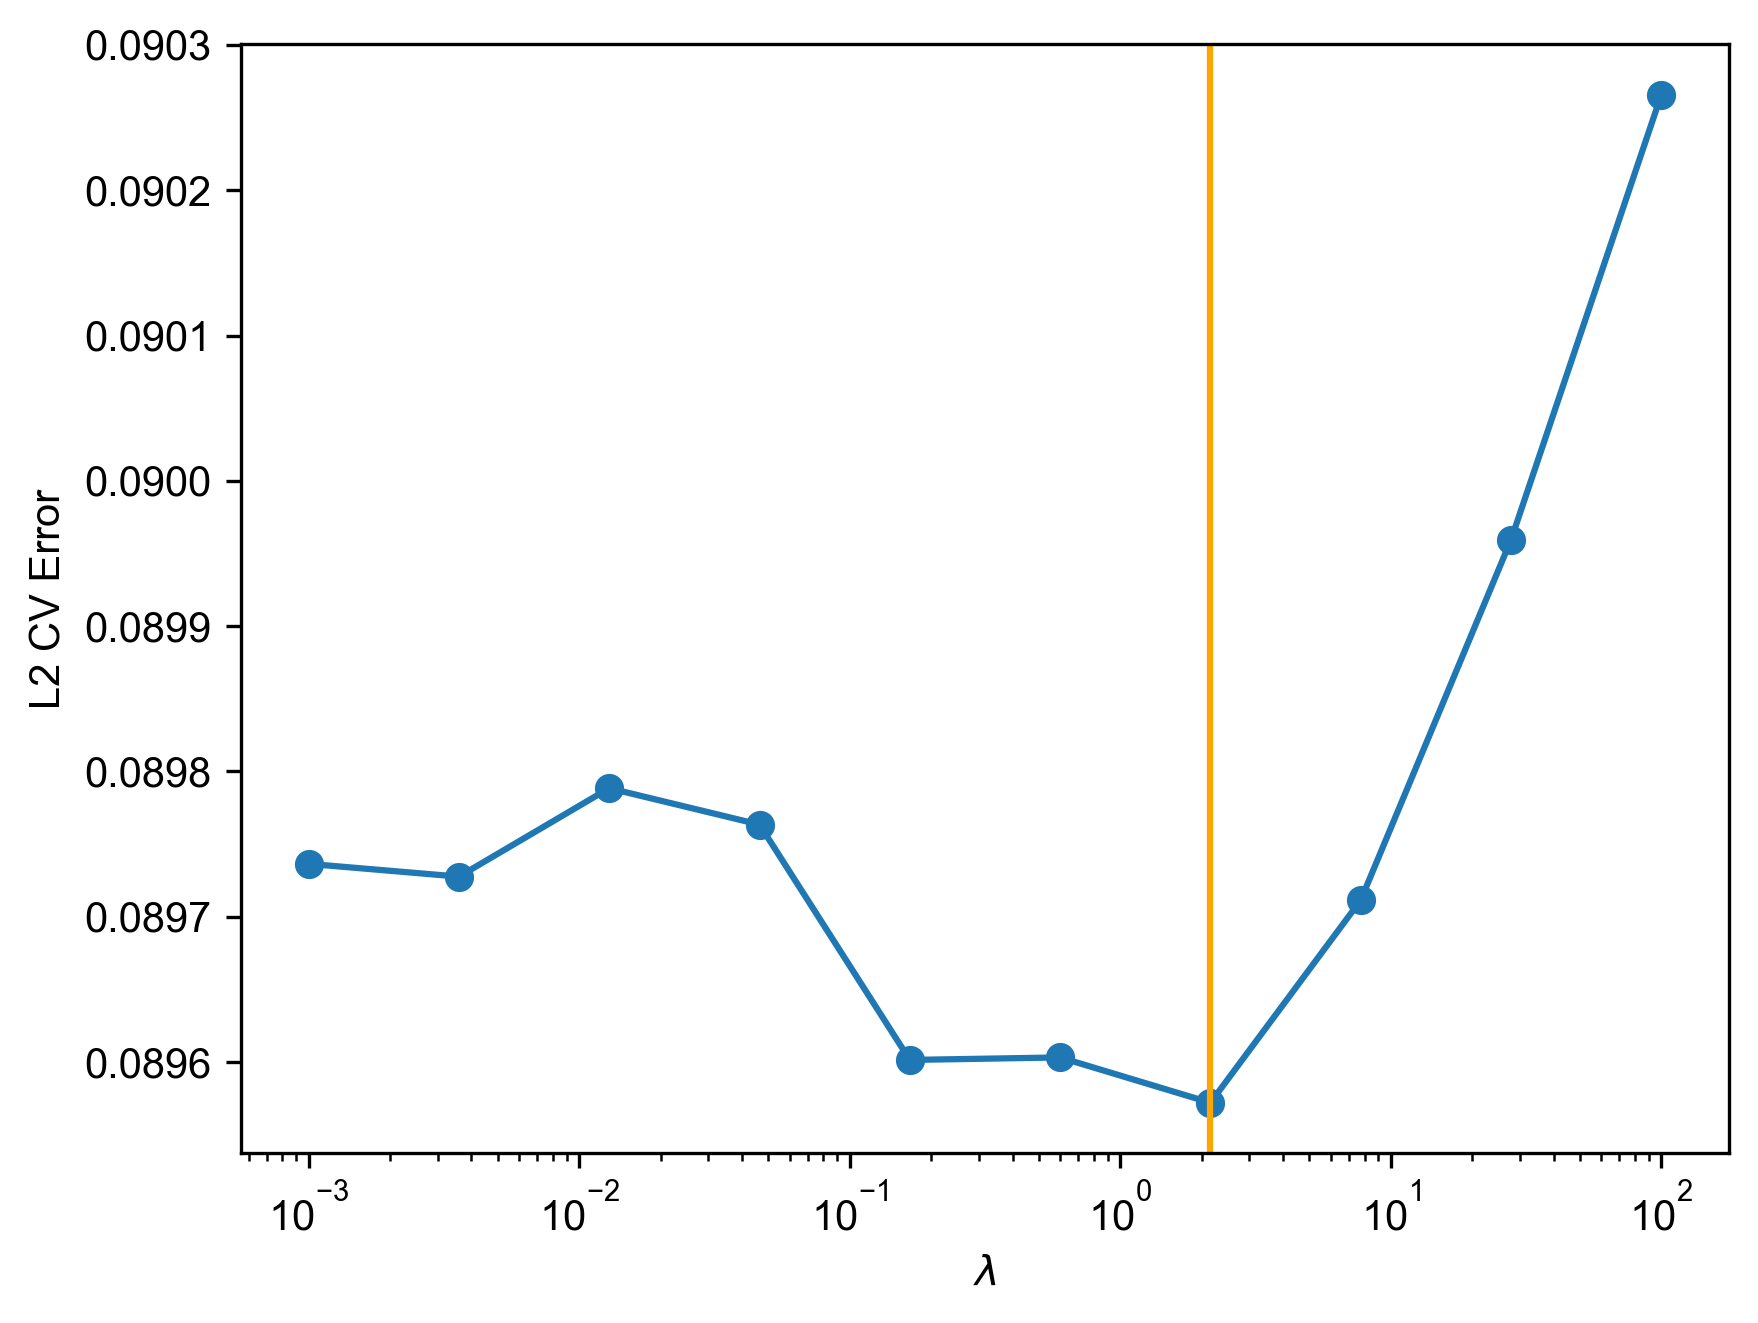

In [657]:
fig, ax = plt.subplots(dpi=200)
ax.plot(lamb_grid, mean_cv_err, "-o");
ax.set_xlabel(r"$\lambda$"); ax.set_xscale('log')
ax.set_ylabel("L2 CV Error");
ax.axvline(lamb_cv, color = "orange")

Lets take a look at a summary of CV:

Text(0.2, 0.85, 'lambda=0.00100\ncv l2 error=0.08974')

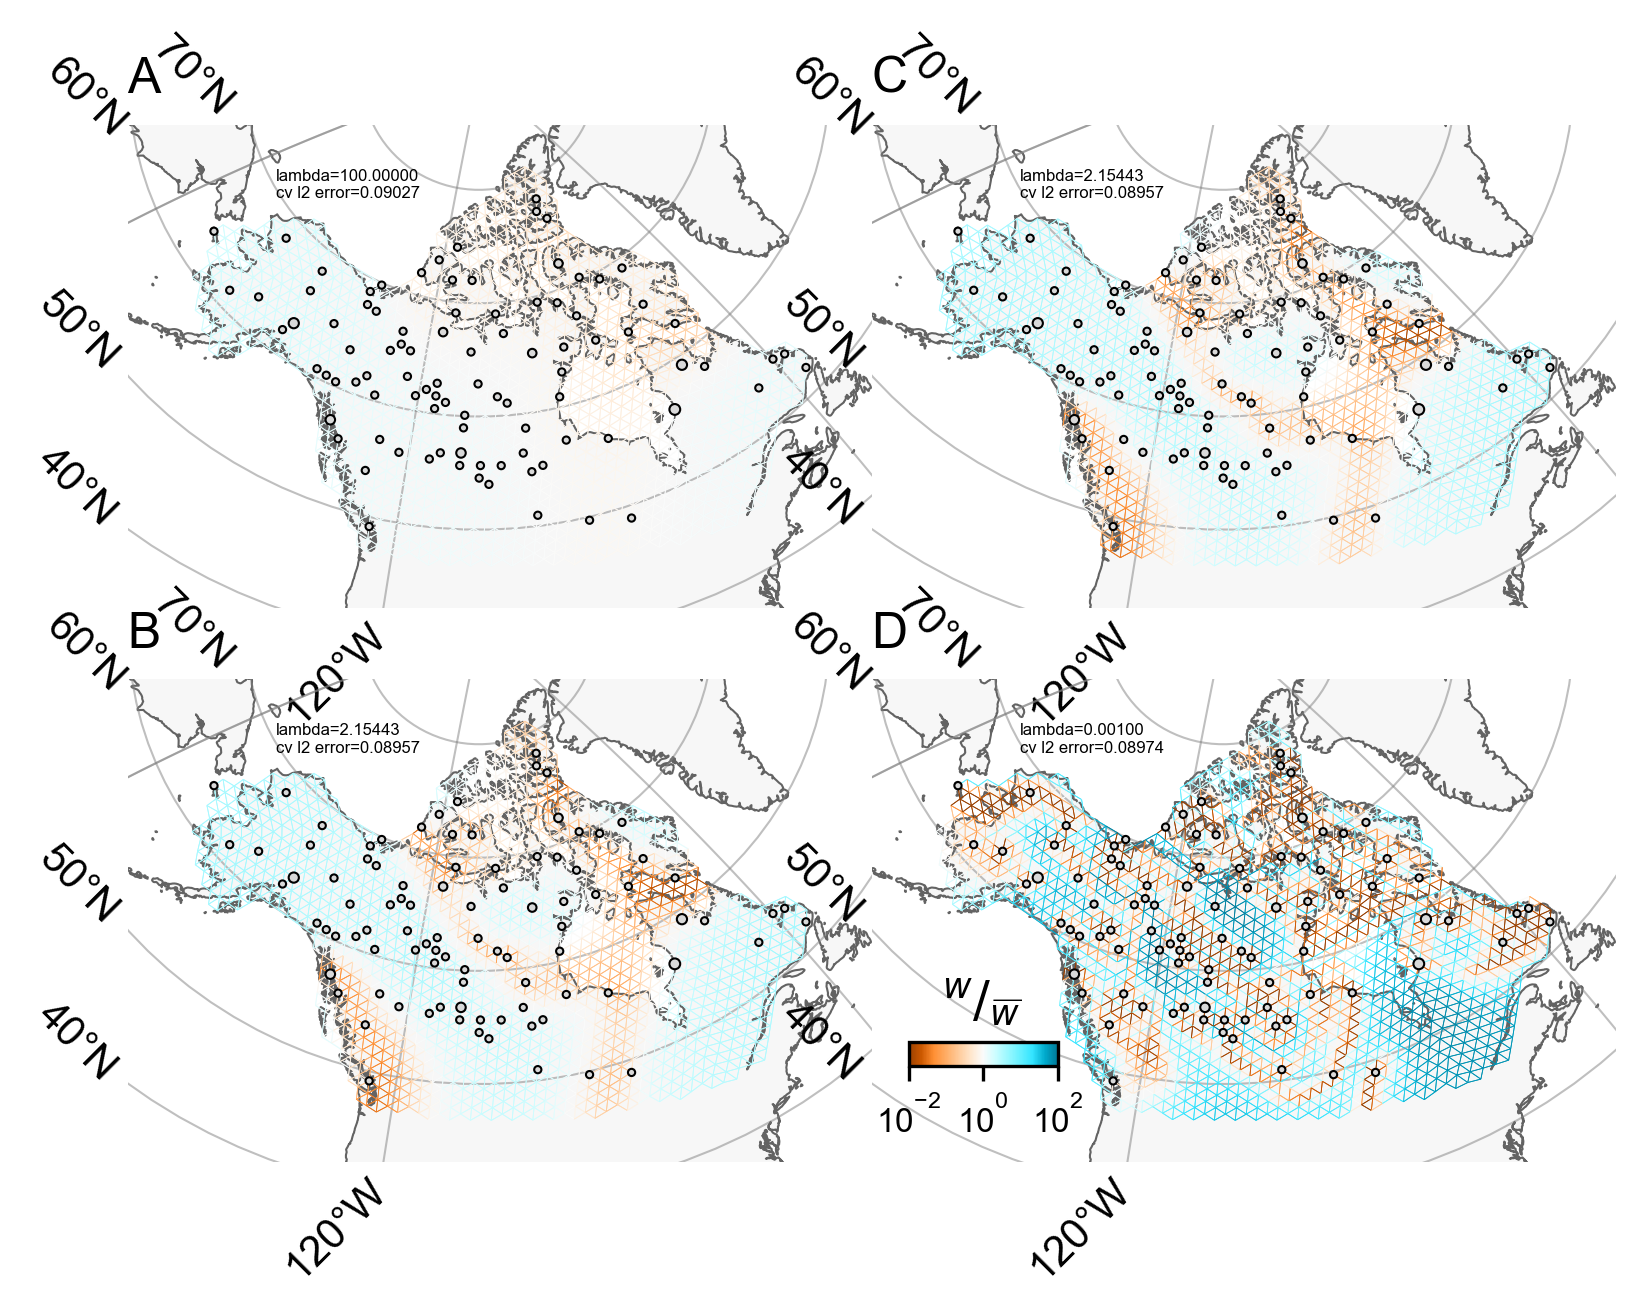

In [659]:
# figure params
projection = ccrs.AzimuthalEquidistant(central_longitude=-108.842926, central_latitude=66.037547)
title_loc = "left"
title_pad = "-10"
title_fontsize = 12
edge_width = .2
edge_alpha = 1
edge_zorder = 3
obs_node_size = 3
obs_node_linewidth = .4
cbar_font_size = 8
cbar_ticklabelsize = 8
cbar_orientation = "horizontal"

# figure setup
fig = plt.figure(dpi=300)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, wspace=0.0, hspace=0.0)

# axis 00 
ax_00 = fig.add_subplot(spec[0, 0], projection=projection)
ax_00.set_title("A", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_grid[0]))
v = Viz(ax_00, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_00.text(.2, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_grid[0], mean_cv_err[0, 0]), 
           fontdict={"fontsize": 4}, transform = ax_00.transAxes)

# axis 10
ax_10 = fig.add_subplot(spec[1, 0], projection=projection)
ax_10.set_title("B", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_grid[3]))
v = Viz(ax_10, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20,
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_10.text(.2, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_grid[3], mean_cv_err[3, 0]), 
           fontdict={"fontsize": 4}, transform = ax_10.transAxes)

# axis 01
ax_01 = fig.add_subplot(spec[0, 1], projection=projection)
ax_01.set_title("C", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_cv))
v = Viz(ax_01, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
ax_01.text(.2, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_cv, mean_cv_err[np.argmin(mean_cv_err), 0]), 
           fontdict={"fontsize": 4}, transform = ax_01.transAxes)

# axis 11
ax_11 = fig.add_subplot(spec[1, 1], projection=projection)
ax_11.set_title("D", loc=title_loc, pad=title_pad, fontdict={"fontsize": title_fontsize})
sp_graph.fit(float(lamb_grid[-1]))
v = Viz(ax_11, sp_graph, projection=projection, edge_width=edge_width, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=obs_node_size, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
v.cbar_font_size = cbar_font_size
v.cbar_orientation = cbar_orientation
v.cbar_ticklabelsize = cbar_ticklabelsize
v.draw_edge_colorbar()
ax_11.text(.2, .85, "lambda={:.5f}\ncv l2 error={:.5f}".format(lamb_grid[-1], mean_cv_err[-1, 0]), 
           fontdict={"fontsize": 4}, transform = ax_11.transAxes)